# Image renconstruction using various activation functions

Let's import the necessary libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import os
from PIL import Image
from skimage.filters import sobel,laplace
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

Loading image

In [ ]:
data = MNIST(root='/root',train=True,download=True)
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /root
    Split: Train

In [ ]:
data.data.shape

torch.Size([60000, 28, 28])

In [ ]:
image = data.data[0]
image.shape

torch.Size([28, 28])

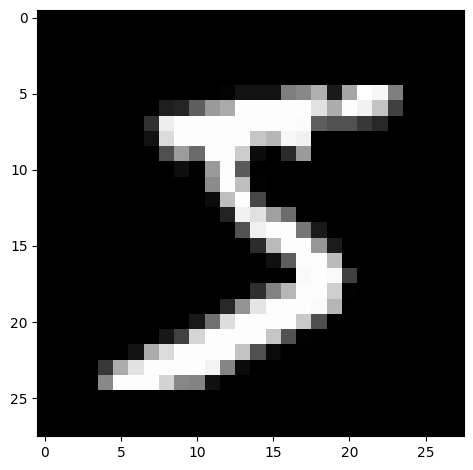

In [ ]:
plt.imshow(image,cmap='gray')
plt.tight_layout()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
scaler_img = preprocessing.MinMaxScaler().fit(image.reshape(-1, 1))
img_scaled = scaler_img.transform(image.reshape(-1, 1)).reshape(image.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape

cpu


torch.Size([28, 28])

In [ ]:
img_scaled = torch.unsqueeze(img_scaled,dim=0)
image.min(),image.max(),img_scaled.min(),img_scaled.max()

(tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8),
 tensor(0., dtype=torch.float64),
 tensor(1., dtype=torch.float64))

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y



In [ ]:
Coords, pixels = create_coordinate_map(img_scaled)
Coords.shape, pixels.shape

(torch.Size([784, 2]), torch.Size([784, 1]))

In [ ]:
Coords[:5],pixels[:5]

(tensor([[0., 0.],
         [0., 1.],
         [0., 2.],
         [0., 3.],
         [0., 4.]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Coords.cpu())

# Scale the X coordinates
Coords_scaled = scaler_X.transform(Coords.cpu())

# Move the scaled X coordinates to the GPU
Coords_scaled = torch.tensor(Coords_scaled).to(device)

# Set to dtype float32
Coords_scaled = Coords_scaled.float()
Coords.shape,Coords.min(),Coords.max()

(torch.Size([784, 2]), tensor(0.), tensor(27.))

In [ ]:
Coords_scaled.shape,Coords_scaled.min(),Coords_scaled.max()

(torch.Size([784, 2]), tensor(-1.), tensor(1.))

In [ ]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad
def Laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


In [ ]:
# Model
class NN(nn.Module):

  def _init_siren(self, omega):
      self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
      for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
          layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/omega,
                                      np.sqrt(6/self.fc2.in_features)/omega)

  def __init__(self, activation=torch.sin, n_out=1, omega=1.0,s=128):
        super().__init__()
        self.activation = activation
        self.omega = omega
        self.fc1 = nn.Linear(2, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(omega=self.omega)

  def forward(self, x):
      x = self.activation(self.omega*self.fc1(x))
      x = self.activation(self.omega*self.fc2(x))
      x = self.activation(self.omega*self.fc3(x))
      x = self.activation(self.omega*self.fc4(x))
      return self.fc5(x)

In [ ]:
# Shuffle data

# shuffled index
sh_index = torch.randperm(Coords_scaled.shape[0])

# Shuffle the dataset
Coords_sh = Coords_scaled[sh_index]
pixels_sh = pixels[sh_index]

In [ ]:
nns = {}
nns["mnist"] = {}
nns["mnist"]["relu"] = NN(activation=torch.relu).to(device)
nns["mnist"]["sin"] = NN(activation=torch.sin, omega=5).to(device)
nns["mnist"]["tanh"] = NN(activation=torch.tanh).to(device)


In [ ]:
nns["mnist"]["relu"](Coords_sh).shape, nns["mnist"]["sin"](Coords_sh).shape

(torch.Size([784, 1]), torch.Size([784, 1]))

In [ ]:
Coords_sh.get_device()

-1

In [ ]:
n_iter = 2000

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train(nns["mnist"]["relu"], lr=3e-4, X=Coords_sh, Y=pixels_sh, epochs=n_iter)

Epoch 0 loss: 0.124708
Epoch 100 loss: 0.057384
Epoch 200 loss: 0.015448
Epoch 300 loss: 0.007028
Epoch 400 loss: 0.004833
Epoch 500 loss: 0.003784
Epoch 600 loss: 0.003161
Epoch 700 loss: 0.002692
Epoch 800 loss: 0.002465
Epoch 900 loss: 0.002187
Epoch 1000 loss: 0.001870
Epoch 1100 loss: 0.001652
Epoch 1200 loss: 0.001581
Epoch 1300 loss: 0.001353
Epoch 1400 loss: 0.001245
Epoch 1500 loss: 0.001054
Epoch 1600 loss: 0.000952
Epoch 1700 loss: 0.000897
Epoch 1800 loss: 0.000800
Epoch 1900 loss: 0.000816


0.0008279115427285433

In [ ]:
grad = np.stack([sobel(img_scaled.to("cpu").detach().numpy(), axis=0), sobel(img_scaled.to("cpu").detach().numpy(), axis=1)], axis=-1)
grad_norm = np.linalg.norm(grad, axis=-1)
grad.shape,grad_norm.shape

((1, 28, 28, 2), (1, 28, 28))

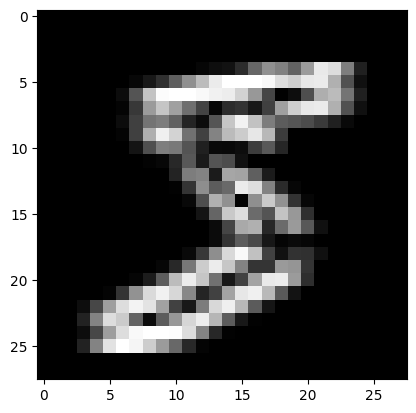

In [ ]:
plt.imshow(torch.einsum("chw -> hwc",torch.tensor(grad_norm)),cmap='gray')
plt.show()

Text(0.5, 1.0, 'Original Laplacian')

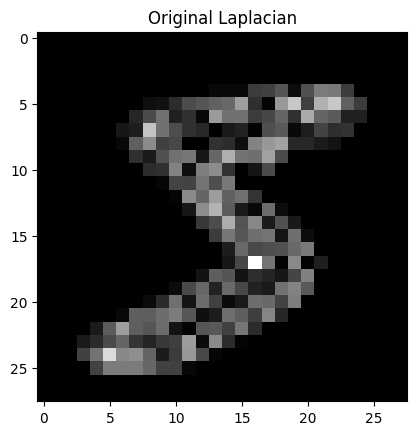

In [ ]:
original_img_np = img_scaled.cpu().permute(1, 2, 0).numpy()
original_laplacian = laplace(original_img_np)
plt.imshow(np.linalg.norm(original_laplacian,axis=2).reshape(28,28,1),cmap='gray')
plt.title("Original Laplacian")

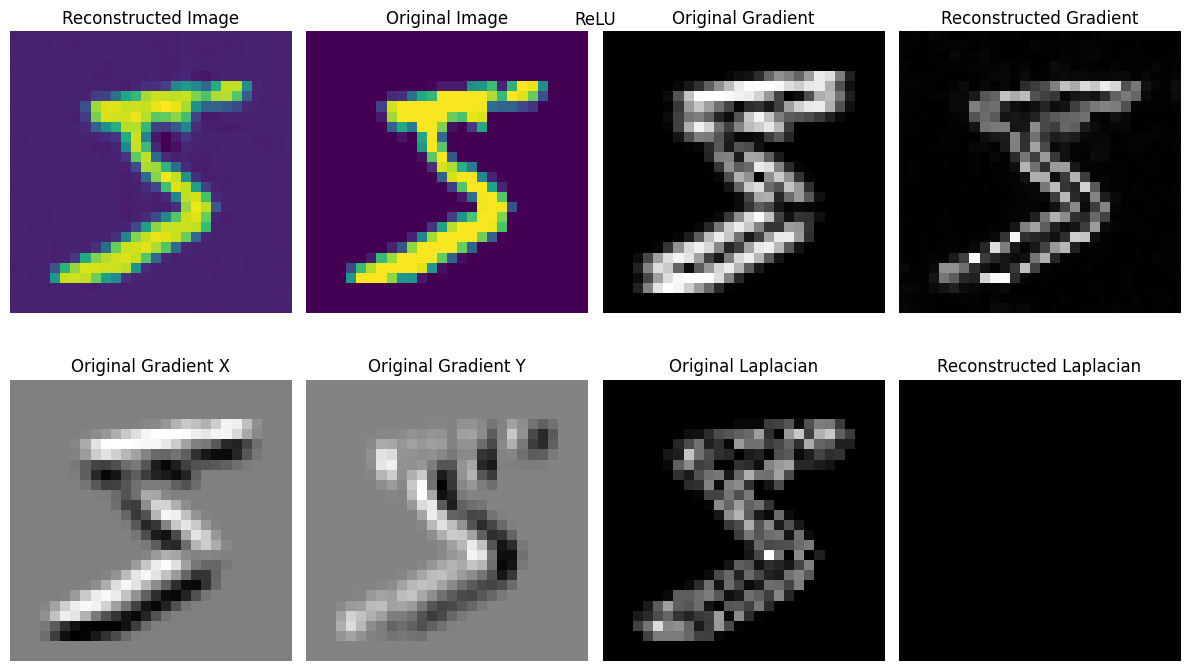

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape

    original_img = original_img.detach()
    X.requires_grad_(True)
    net.eval()
    outputs = net(X)
    outputs = outputs.reshape(height, width, num_channels)
    grad = gradient(outputs,X)
    lp = Laplace(outputs,X)


    # Compute gradient and Laplacian of original and reconstructed images using skimage
    original_img_np = original_img.cpu().permute(1, 2, 0).numpy()
    reconstructed_img_np = outputs.detach().cpu().numpy()

    original_gradient_x = sobel(original_img_np, axis=0)
    original_gradient_y = sobel(original_img_np, axis=1)
    original_gradient = np.stack([sobel(original_img.to("cpu").detach().numpy(), axis=0), sobel(original_img.to("cpu").detach().numpy(), axis=1)], axis=-1)
    grad_norm = np.linalg.norm(original_gradient, axis=-1)
    original_laplacian = laplace(original_img_np)


    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])
    ax4 = plt.subplot(gs[4])
    ax5 = plt.subplot(gs[5])
    ax6 = plt.subplot(gs[6])
    ax7 = plt.subplot(gs[7])

    ax0.imshow(outputs.detach().cpu().numpy())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
#     print(np.linalg.norm(grad_norm,axis=0).reshape(1,500,500).shape)
    ax2.imshow(torch.einsum("chw -> hwc",torch.tensor(np.linalg.norm(grad_norm,axis=0).reshape(1,28,28))),cmap='gray')
    ax2.set_title("Original Gradient")

    ax3.imshow(grad.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax3.set_title("Reconstructed Gradient")

    ax4.imshow(original_gradient_x, cmap='gray')
    ax4.set_title("Original Gradient X")

    ax5.imshow(original_gradient_y, cmap='gray')
    ax5.set_title("Original Gradient Y")

    ax6.imshow(np.linalg.norm(original_laplacian,axis=2).reshape(28,28,1),cmap='gray')
    ax6.set_title("Original Laplacian")

    ax7.imshow(lp.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax7.set_title("Reconstructed Laplacian")

    for a in [ax0, ax1, ax2, ax3, ax4, ax5,ax6,ax7]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

    return outputs,grad,lp



outputs_relu,grad_relu,lp_relu = plot_reconstructed_and_original_image(img_scaled, nns["mnist"]["relu"], Coords_scaled, title="ReLU")


In [ ]:
imgs_sin = train(nns["mnist"]["sin"], lr=3e-4, X=Coords_sh, Y=pixels_sh, epochs=n_iter)

Epoch 0 loss: 0.135896
Epoch 100 loss: 0.006196
Epoch 200 loss: 0.002919
Epoch 300 loss: 0.001405
Epoch 400 loss: 0.000737
Epoch 500 loss: 0.000398
Epoch 600 loss: 0.000234
Epoch 700 loss: 0.000134
Epoch 800 loss: 0.000075
Epoch 900 loss: 0.000082
Epoch 1000 loss: 0.000028
Epoch 1100 loss: 0.000019
Epoch 1200 loss: 0.000064
Epoch 1300 loss: 0.000120
Epoch 1400 loss: 0.000006
Epoch 1500 loss: 0.000005
Epoch 1600 loss: 0.000005
Epoch 1700 loss: 0.000003
Epoch 1800 loss: 0.000189
Epoch 1900 loss: 0.000002


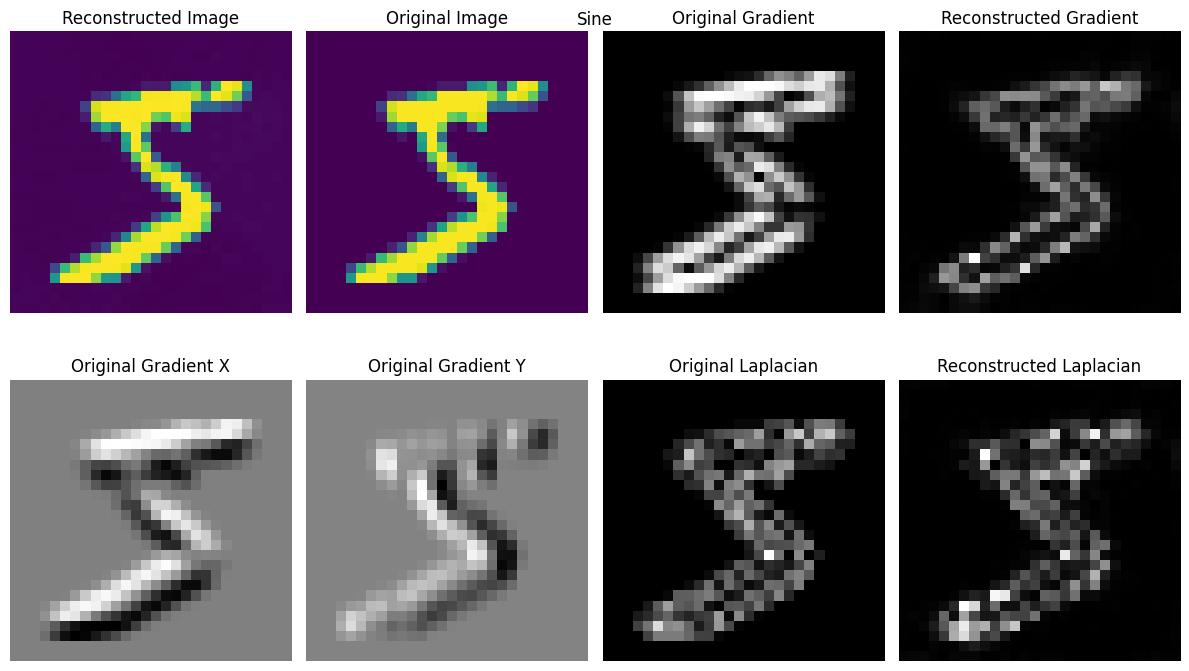

In [ ]:
outputs_sin,grad_sin,lp_sin = plot_reconstructed_and_original_image(img_scaled, nns["mnist"]["sin"], Coords_scaled, title="Sine")

In [ ]:
imgs_tanh = train(nns["mnist"]["tanh"], lr=3e-4, X=Coords_sh, Y=pixels_sh, epochs=n_iter)

Epoch 0 loss: 0.127715
Epoch 100 loss: 0.076765
Epoch 200 loss: 0.072533
Epoch 300 loss: 0.065501
Epoch 400 loss: 0.045376
Epoch 500 loss: 0.032519
Epoch 600 loss: 0.023787
Epoch 700 loss: 0.019351
Epoch 800 loss: 0.016675
Epoch 900 loss: 0.014709
Epoch 1000 loss: 0.012673
Epoch 1100 loss: 0.011636
Epoch 1200 loss: 0.010895
Epoch 1300 loss: 0.010314
Epoch 1400 loss: 0.009828
Epoch 1500 loss: 0.009476
Epoch 1600 loss: 0.009905
Epoch 1700 loss: 0.008863
Epoch 1800 loss: 0.008430
Epoch 1900 loss: 0.008168


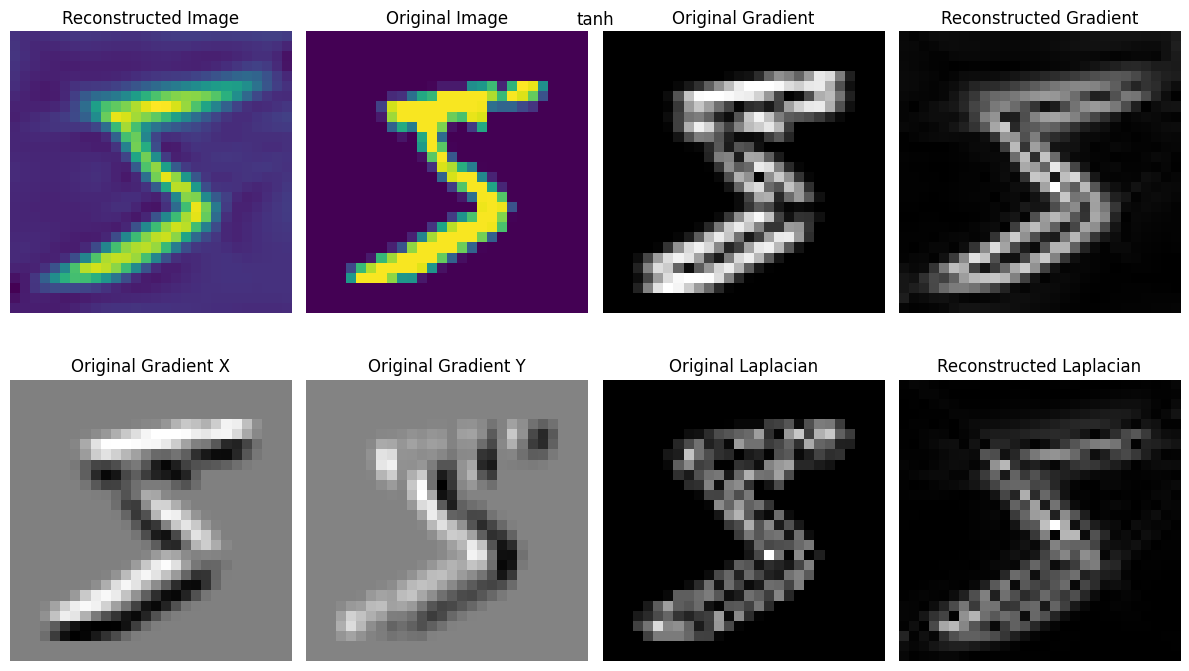

In [ ]:
outputs_tanh,grad_tanh,lp_tanh = plot_reconstructed_and_original_image(img_scaled, nns["mnist"]["tanh"], Coords_scaled, title="tanh")

In [ ]:
# plot figure comparisons
def plot_comparisons():
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])
    ax4 = plt.subplot(gs[4])
    ax5 = plt.subplot(gs[5])
    ax6 = plt.subplot(gs[6])
    ax7 = plt.subplot(gs[7])
    ax8 = plt.subplot(gs[8])
    ax9 = plt.subplot(gs[9])
    ax10 = plt.subplot(gs[10])
    ax11 = plt.subplot(gs[11])


    ax0.imshow(torch.einsum("chw -> hwc",img_scaled).detach().cpu().numpy(),cmap='gray')
    ax0.set_title("Ground Truth Image",size=9)
    ax0.axis("off")

    ax1.imshow(outputs_relu.detach().cpu().numpy(),cmap='gray')
    ax1.set_title("ReLU Image",size=9)
    ax1.axis("off")

    ax2.imshow(outputs_sin.detach().cpu().numpy(),cmap='gray')
    ax2.set_title("Sine Image",size=9)
    ax2.axis("off")

    ax3.imshow(outputs_tanh.detach().cpu().numpy(),cmap='gray')
    ax3.set_title("tanh Image",size=9)
    ax3.axis("off")

    ax4.imshow(torch.einsum("chw -> hwc",torch.tensor(grad_norm)),cmap='gray')
    ax4.set_title("Ground Truth Gradient",size=9)
    ax4.axis("off")

    ax5.imshow(grad_relu.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax5.set_title("ReLU Gradient",size=9)
    ax5.axis("off")

    ax6.imshow(grad_sin.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax6.set_title("Sine Gradient",size=9)
    ax6.axis("off")

    ax7.imshow(grad_tanh.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax7.set_title("tanh Gradient",size=9)
    ax7.axis("off")

    ax8.imshow(np.linalg.norm(original_laplacian,axis=2).reshape(28,28,1),cmap='gray')
    ax8.set_title("Original Laplacian")
    ax8.axis("off")

    ax9.imshow(lp_relu.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax9.set_title("ReLU Laplacian",size=9)
    ax9.axis("off")

    ax10.imshow(lp_sin.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax10.set_title("Sine Laplacian",size=9)
    ax10.axis("off")

    ax11.imshow(lp_tanh.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
    ax11.set_title("tanh Laplacian",size=9)
    ax11.axis("off")



    plt.tight_layout()
    plt.show()


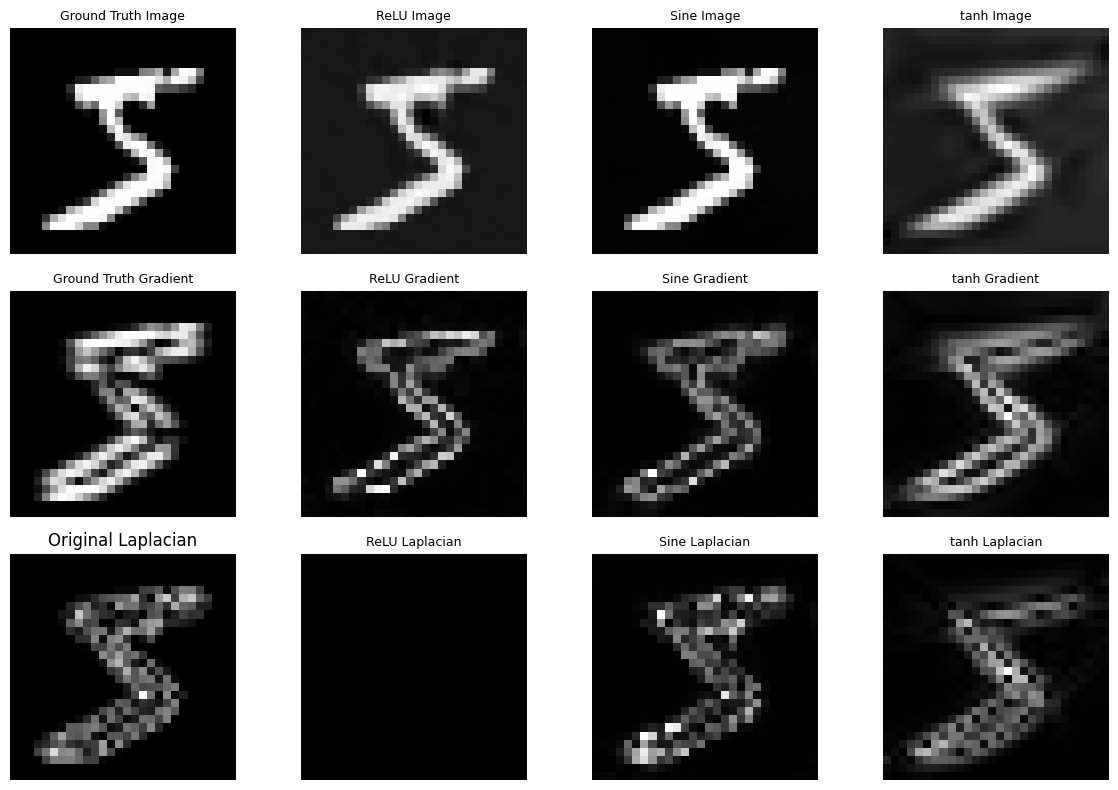

In [ ]:
plot_comparisons()

In [ ]:
grad_relu.shape

torch.Size([784, 2])

In [ ]:
# Analyzing siren for different values of omega

omega_values = [w for w in range(1,34,5)]
omega_values

[1, 6, 11, 16, 21, 26, 31]

In [ ]:
def plot_omega_comparisons():
    fig,ax = plt.subplots(3,7,figsize=(15,5))
    Coords_scaled.requires_grad_(True)
    for w in range(len(omega_values)):
        nns["mnist"][f"{omega_values[w]}"] = NN(activation=torch.sin, omega=omega_values[w]).to(device)
        net = nns["mnist"][f"{omega_values[w]}"]
        imgs_sin_w = train(net, lr=3e-4, X=Coords_sh, Y=pixels_sh, epochs=n_iter,verbose=False)
        net.eval()
        outputs = net(Coords_scaled)
        outputs = outputs.reshape(28, 28, 1)
        grad = gradient(outputs,Coords_scaled)
        lp = Laplace(outputs,Coords_scaled)


        ax[0,w].imshow(outputs.detach().cpu().numpy(),cmap='gray')
        ax[0,w].set_title(f"Reconstructed Image, omega={omega_values[w]}",size=7)
        ax[0,w].axis("off")

        ax[1,w].imshow(grad.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
        ax[1,w].set_title("Reconstructed Gradient",size=7)
        ax[1,w].axis("off")

        ax[2,w].imshow(lp.norm(dim=-1).cpu().view(28,28).detach().numpy(),cmap='gray')
        ax[2,w].set_title("Reconstructed Laplacian",size=7)
        ax[2,w].axis("off")




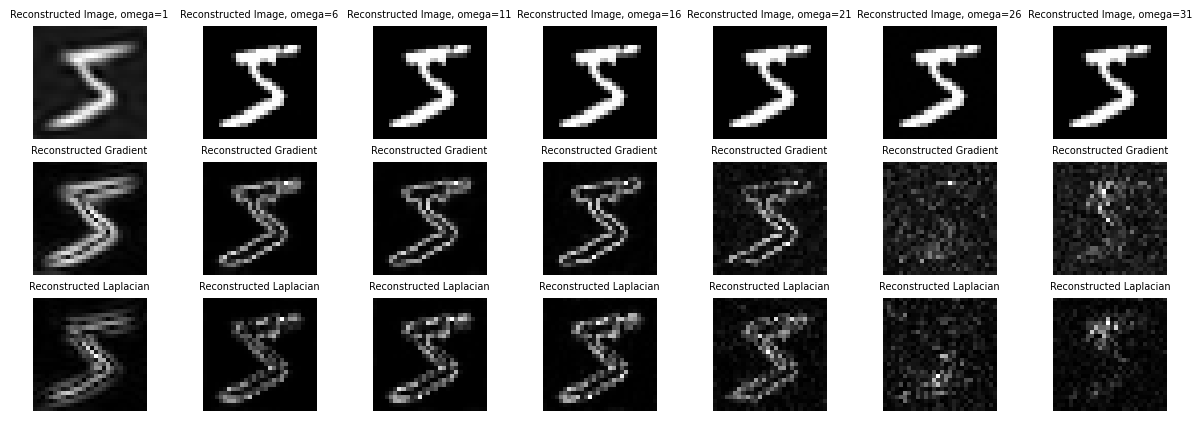

In [ ]:
plot_omega_comparisons()